To keep discussion succint, we use feature selection and cross-validation as typical representatives of the composite process and a resampling evaluation rule, respectively. We then describe appropriate implementation of:
1. Feature Selection and Model Evaluation Using Cross-Validation
2. Feature and Model Selection Using Cross-Validation
3. Nested Cross-Validation for Feature and Model Selection, and Evaluation

### 11.1 Using Cross-Validation Along with Other Steps in a Nutshell

- The held-out fold should not be used in steps such as normalization and/or feature selection/extraction
- $\Xi$ is a composite transformer, which means it is a composite estimator that transforms data
- The correct way of using K-fold CV to evaluate $\phi_{tr}(x)$ is to apply K-fold  CV external to the composite process $\Xi$

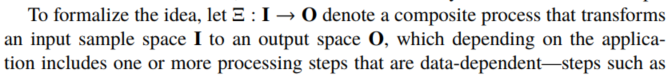

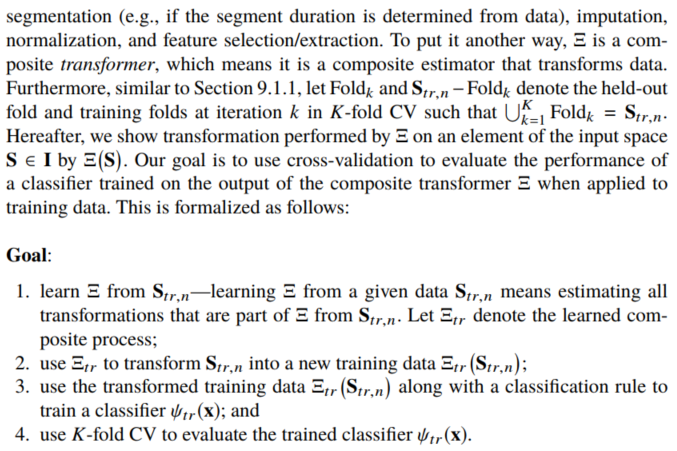

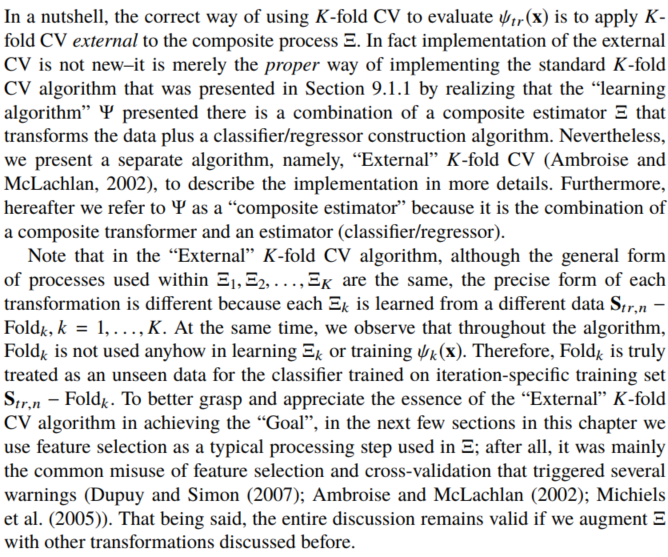

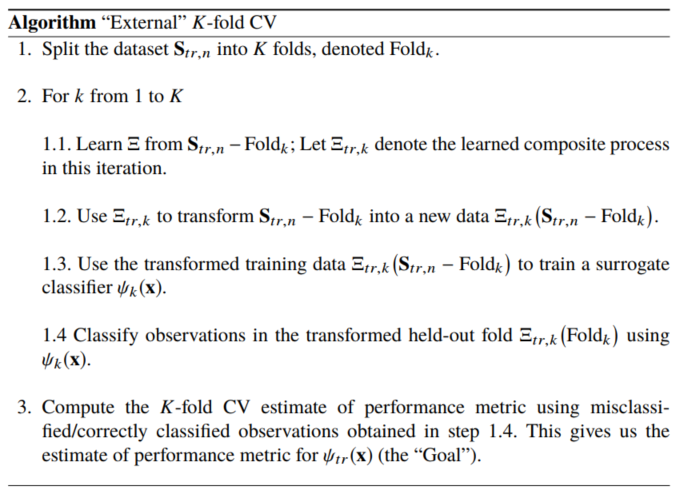

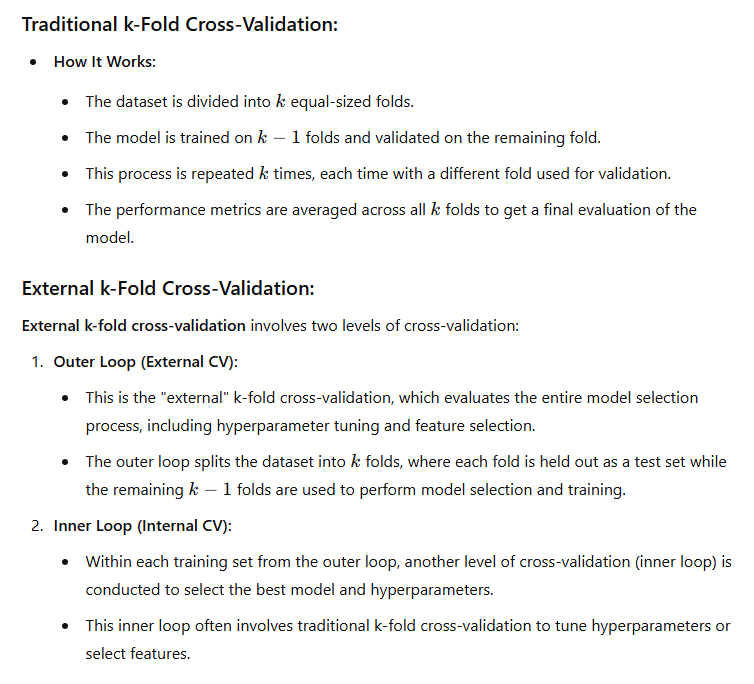

### 11.2 A Common Mistake

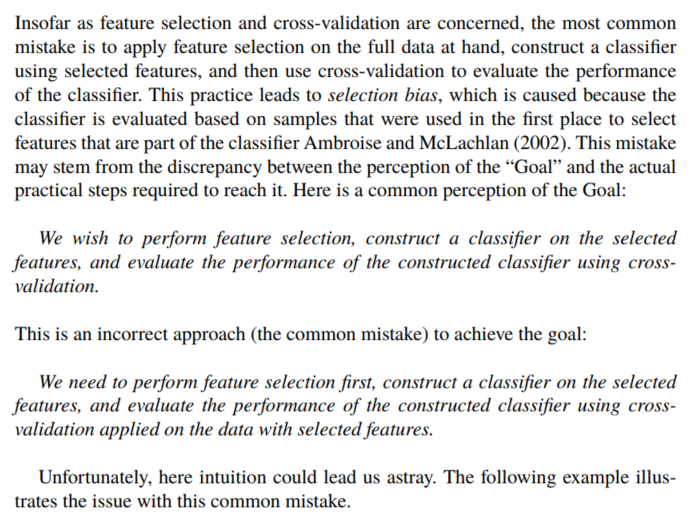

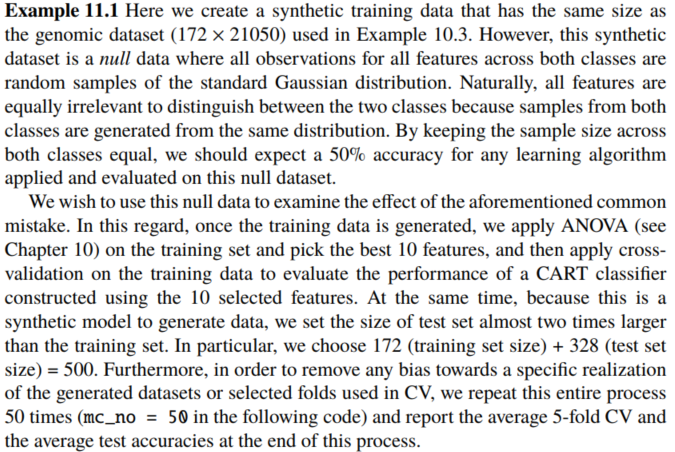

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as CART

np.random.seed(42)
n_features = 21050
n_sample = 500 # size of training + test sets
ratio_train2full = 172/500 # the proportion of training data to n_sample
mc_no = 50 # number of Monte Carlo repetitions
kfold = 5 # K-fold CV
cv_scores_matrix = np.zeros((mc_no, kfold))
test_scores = np.zeros(mc_no)
for j in np.arange(mc_no):
  X = np.random.normal(0, 1, size=(n_sample, n_features))
  y = np.concatenate((np.ones(n_sample//2, dtype='int_'), np.zeros(n_sample//2, dtype='int_')))
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=ratio_train2full)
  filter_KBest = SelectKBest(k=10).fit(X_train, y_train)
  X_train_filtered = filter_KBest.transform(X_train)
  strkfold = StratifiedKFold(n_splits=kfold, shuffle=True)
  cart = CART()
  cv_scores_matrix[j,:] = cross_val_score(cart, X_train_filtered, y_train, cv=strkfold)
  X_test_filtered = filter_KBest.transform(X_test)
  final_cart = cart.fit(X_train_filtered, y_train)
  test_scores[j] = final_cart.score(X_test_filtered, y_test)

print("the average K-fold CV accuracy is: {:.3f}".format(cv_scores_matrix.mean()))
print("the average test accuracy is: {:.3f}".format(test_scores.mean()))

the average K-fold CV accuracy is: 0.649
the average test accuracy is: 0.493


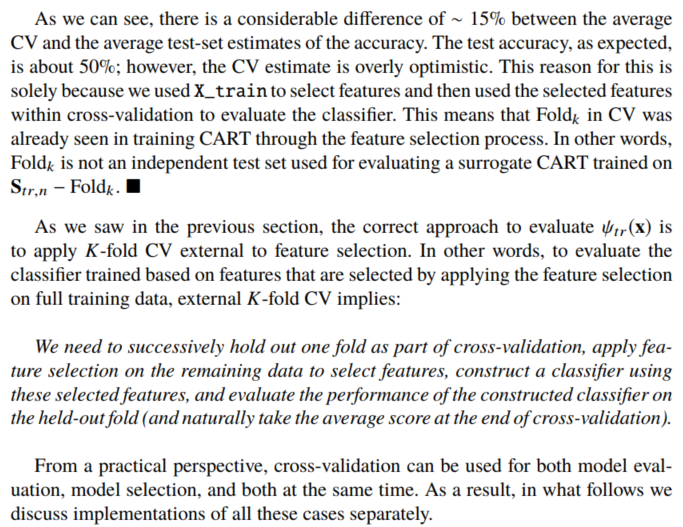

### 11.3 Feature Selection and Model Evaluation Using Cross-Validation

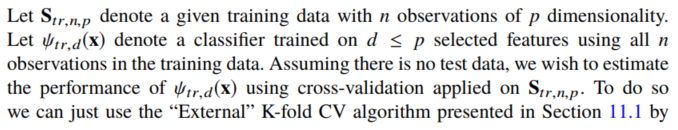

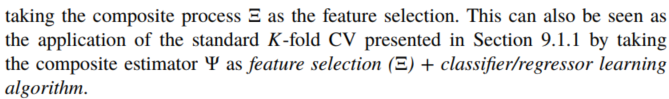

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier as CART
from sklearn.feature_selection import SelectKBest

# a list of tuples (_, transformer) with the last one being a tuple of (_, estimator)
pipe = Pipeline(steps=[("dimen_reduce", PCA(n_components=10)), ("feature select", SelectKBest(k=5)), ("classifier", CART())])

#### Example

The average CV estimate of the accuracy is very close to that of test-set estimate and both are about 50% as they should (recall that we had a null dataset)

The performance estimate of our final constructed classifier, which itself is different from all surrogate classifiers. This is the classifier constructed using **final_cart = pipe.fit(X_train, y_train)** —we name it “final_cart” because this is what we use for predicting unseen observations in the future

In [3]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as CART
from sklearn.pipeline import Pipeline

np.random.seed(42)
n_features = 21050
n_sample = 500 # size of training + test set
ratio_train2full = 172/500 # the proportion of training data to n_sample
mc_no = 50 # number of Monte Carlo repetitions
kfold = 5 # K-fold CV
cv_scores_matrix = np.zeros((mc_no, kfold))
test_scores = np.zeros(mc_no)
strkfold = StratifiedKFold(n_splits=kfold, shuffle=True)
pipe = Pipeline(steps=[('kbest', SelectKBest(k=10)), ('clf', CART())]) # kbest and clf are arbitrary names

for j in np.arange(mc_no):
  X = np.random.normal(0, 1, size=(n_sample, n_features))
  y = np.concatenate((np.ones(n_sample//2, dtype='int_'), np.zeros(n_sample//2, dtype='int_')))
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=ratio_train2full)
  cv_scores_matrix[j,:] = cross_val_score(pipe, X_train, y_train, cv=strkfold)
  final_cart = pipe.fit(X_train, y_train)
  test_scores[j] = final_cart.score(X_test, y_test)
  
print("the average K-fold CV accuracy is: {:.3f}".format(cv_scores_matrix.mean()))
print("the average test accuracy is: {:.3f}".format(test_scores.mean()))

the average K-fold CV accuracy is: 0.506
the average test accuracy is: 0.493


### 11.4 Feature and Model Selection Using Cross-Validation

A common approach for model selection is the grid search cross-validation. However, once feature selection is desired, the search for the best model should be conducted by taking into account the joint relationship between the search and the feature selection

The best feature-model is the one that leads to the highest CV score across all examined combinations of features and models (i.e., a joint feature-model selection)

#### Example 1

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as CART
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LRR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV

np.random.seed(42)
n_features = 1000
acc_test = np.zeros(n_features)
kfold = 5 # K-fold CV
X, y = make_classification(n_samples=1000, n_features=n_features, n_informative=10, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, class_sep=1, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.2)
pipe = Pipeline(steps=[('kbest', SelectKBest()), ('clf', CART())]) # kbest and clf are arbitrary names
strkfold = StratifiedKFold(n_splits=kfold, shuffle=True)

param_grid = [
  {'clf': [LRR()], 'clf__penalty': ['l2'], 'clf__C': [0.1, 1, 10],
  'kbest': [SelectKBest()], 'kbest__k': [5, 10, 50]},
  {'clf': [LRR()], 'clf__penalty': ['l1'], 'clf__C': [0.1, 1, 10],
  'clf__solver': ['liblinear'], 'kbest': ['passthrough']},
  {'clf': [CART(), RF()], 'clf__min_samples_leaf': [1, 5],
  'kbest': [SelectKBest()], 'kbest__k': [5, 10, 50]}
  ]

gscv = GridSearchCV(pipe, param_grid, cv=strkfold)
score_best_estimator=gscv.fit(X_train, y_train).score(X_test, y_test)

print('the highest score is: {:.3f}'.format(gscv.best_score_))
print('the best composite estimator is: {}'.format(gscv.best_estimator_))
print('the best combination is: {}'.format(gscv.best_params_))
print('the accuracy of the best estimator on the test data is: {:.3f}'.format(score_best_estimator))
df = pd.DataFrame(gscv.cv_results_)
df # uncomment this to see all 24 combinations examined in this example

the highest score is: 0.950
the best composite estimator is: Pipeline(steps=[('kbest', SelectKBest()), ('clf', RandomForestClassifier())])
the best combination is: {'clf': RandomForestClassifier(), 'clf__min_samples_leaf': 1, 'kbest': SelectKBest(), 'kbest__k': 10}
the accuracy of the best estimator on the test data is: 0.929


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__C,param_clf__penalty,param_kbest,param_kbest__k,param_clf__solver,param_clf__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007835,0.001750,0.001011,0.000018,LogisticRegression(),0.1,l2,SelectKBest(),5.0,NaN,NaN,"{'clf': LogisticRegression(), 'clf__C': 0.1, '...",0.925,0.975,0.850,0.850,0.900,0.900,0.047434,13
1,0.008475,0.000406,0.000812,0.000406,LogisticRegression(),0.1,l2,SelectKBest(),10.0,NaN,NaN,"{'clf': LogisticRegression(), 'clf__C': 0.1, '...",0.925,0.950,0.850,0.925,0.925,0.915,0.033912,7
2,0.012071,0.001338,0.001109,0.000812,LogisticRegression(),0.1,l2,SelectKBest(),50.0,NaN,NaN,"{'clf': LogisticRegression(), 'clf__C': 0.1, '...",0.825,0.950,0.825,0.925,0.925,0.890,0.053852,17
3,0.008922,0.001953,0.001127,0.000260,LogisticRegression(),1.0,l2,SelectKBest(),5.0,NaN,NaN,"{'clf': LogisticRegression(), 'clf__C': 1, 'cl...",0.925,0.975,0.825,0.875,0.925,0.905,0.050990,11
4,0.010171,0.001161,0.000994,0.000621,LogisticRegression(),1.0,l2,SelectKBest(),10.0,NaN,NaN,"{'clf': LogisticRegression(), 'clf__C': 1, 'cl...",0.925,0.950,0.825,0.950,0.900,0.910,0.046368,9
5,0.008440,0.001318,0.001080,0.000198,LogisticRegression(),1.0,l2,SelectKBest(),50.0,NaN,NaN,"{'clf': LogisticRegression(), 'clf__C': 1, 'cl...",0.825,0.900,0.800,0.900,0.925,0.870,0.048477,19
6,0.008508,0.001301,0.001307,0.000400,LogisticRegression(),10.0,l2,SelectKBest(),5.0,NaN,NaN,"{'clf': LogisticRegression(), 'clf__C': 10, 'c...",0.925,0.975,0.825,0.875,0.925,0.905,0.050990,11
7,0.009270,0.000861,0.000918,0.000513,LogisticRegression(),10.0,l2,SelectKBest(),10.0,NaN,NaN,"{'clf': LogisticRegression(), 'clf__C': 10, 'c...",0.875,0.950,0.775,0.950,0.850,0.880,0.065955,18
8,0.007839,0.000949,0.001237,0.001057,LogisticRegression(),10.0,l2,SelectKBest(),50.0,NaN,NaN,"{'clf': LogisticRegression(), 'clf__C': 10, 'c...",0.800,0.900,0.800,0.925,0.900,0.865,0.053852,22
9,0.010039,0.002209,0.001304,0.000650,LogisticRegression(),0.1,l1,passthrough,NaN,liblinear,NaN,"{'clf': LogisticRegression(), 'clf__C': 0.1, '...",0.950,0.950,0.900,0.925,0.950,0.935,0.020000,4


#### Example 2

In [2]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as CART
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LRR

np.random.seed(42)
n_features = 21050
n_sample = 500
ratio_train2test = 172/500
mc_no = 20 # number of MC repetitions
kfold = 5 # K-fold CV
cv_scores = np.zeros(mc_no)
test_scores = np.zeros(mc_no)
pipe = Pipeline(steps=[('kbest', SelectKBest()), ('clf', CART())]) # kbest and clf are arbitrary names
strkfold = StratifiedKFold(n_splits=kfold, shuffle=True)

grids = [
  {'clf': [LRR()], 'clf__penalty': ['l2'], 'clf__C': [0.1, 1, 10],
  'kbest': [SelectKBest()], 'kbest__k': [5, 10, 50]},
  {'clf': [LRR()], 'clf__penalty': ['l1'], 'clf__C': [0.1, 1, 10],
  'clf__solver': ['liblinear'], 'kbest': ['passthrough']},
  {'clf': [CART(), RF()], 'clf__min_samples_leaf': [1, 5],
  'kbest': [SelectKBest()], 'kbest__k': [5, 10, 50]}
]

for j in np.arange(mc_no):
  X = np.random.normal(0, 1, size=(n_sample, n_features))
  y = np.concatenate((np.ones(n_sample//2, dtype='int_'), np.zeros(n_sample//2, dtype='int_')))
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=ratio_train2test)
  gscv = GridSearchCV(pipe, grids, cv=strkfold, n_jobs=-1)
  test_scores[j]=gscv.fit(X_train, y_train).score(X_test, y_test)
  cv_scores[j] = gscv.best_score_

print("the average K-fold CV accuracy is: {:.3f}".format(cv_scores.mean()))
print("the average test accuracy is: {:.3f}".format(test_scores.mean()))

the average K-fold CV accuracy is: 0.565
the average test accuracy is: 0.487


### 11.5 Nested Cross-Validation for Feature and Model Selection, and Evaluation

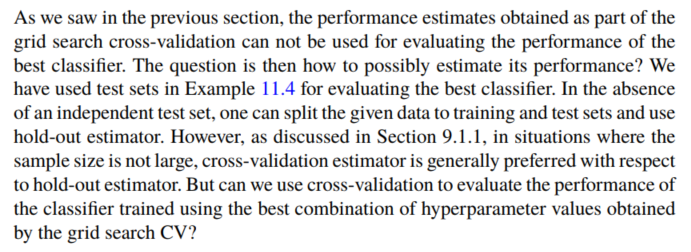

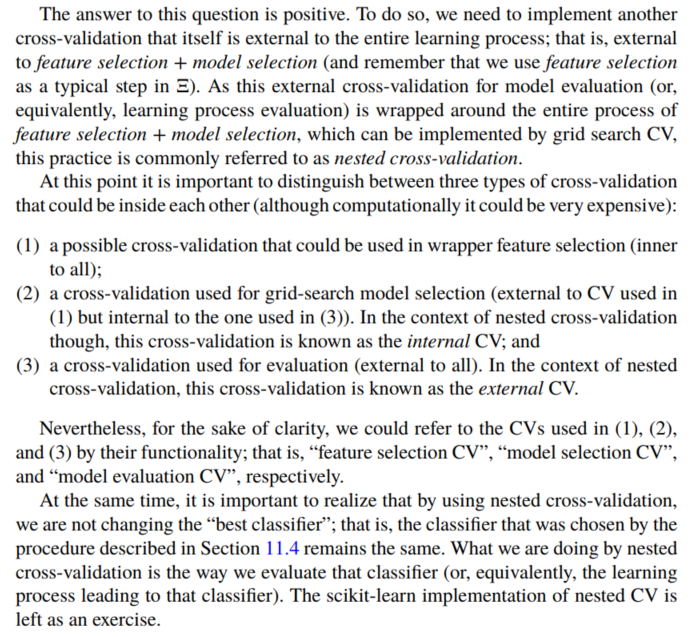